# DATA IMPORT

In [84]:
import pandas as pd
import numpy as np

df_credit = pd.read_csv('credits.csv')
df_rating = pd.read_csv('ratings.csv')
df_movie = pd.read_csv('movies_metadata.csv')
df_keywords = pd.read_csv('keywords.csv')


# Data Preprocessing

In [85]:
df_movie = df_movie[['id', 'original_title', 'title', 'adult', 'belongs_to_collection', 
                     'budget', 'genres', 'original_language', 'popularity',
                     'production_companies', 'production_countries', 'revenue', 
                     'runtime', 'spoken_languages', 'status', 'vote_average',
                     'vote_count']]

df_rating = df_rating[['movieId', 'rating']]



In [86]:
import ast

def convertType(x, typ):
    try:
        return typ(x)
    except ValueError:
        return np.NaN

df_movie['genres_parsed'] = df_movie['genres'].apply(lambda x: [d['name'] for d in ast.literal_eval(x)])
# df_movie['production_countries'] = df_movie['production_countries'].apply(lambda x: d['iso_3166_1'] for d in ast.literal_eval(x))

# convert boolean belongs_to_collection col to integer col with 1 and 0 value
df_movie['is_collection'] = df_movie['belongs_to_collection'].isnull()
df_movie['is_collection'] = df_movie['is_collection'].apply(lambda x: 1 if x==True else 0)

# convert boolean adult col to integer col with 1 and 0 value
df_movie['adult'] = df_movie['adult'].apply(lambda x: 1 if x==True else 0)
df_movie['popularity'] = df_movie['popularity'].apply(lambda x: convertType(x, float))

df_movie['budget'] = df_movie['budget'].apply(lambda x: convertType(x, int))

# DATA ADVERTISING AND BASIC ANALYSIS

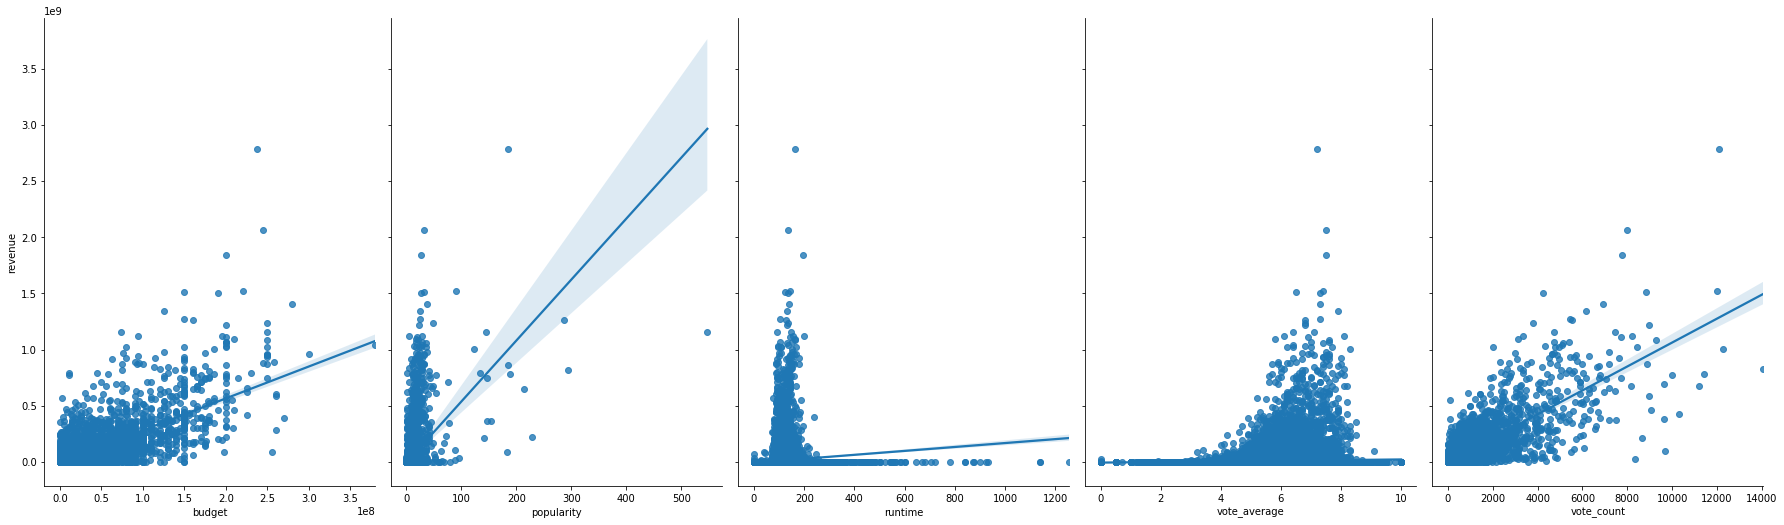

In [6]:
import seaborn as sns
x = ['budget', 'popularity', 'runtime', 'vote_average', 'vote_count']
# plot relationship to revenue and plotting the Least Squares Line
sns.pairplot(df_movie, x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

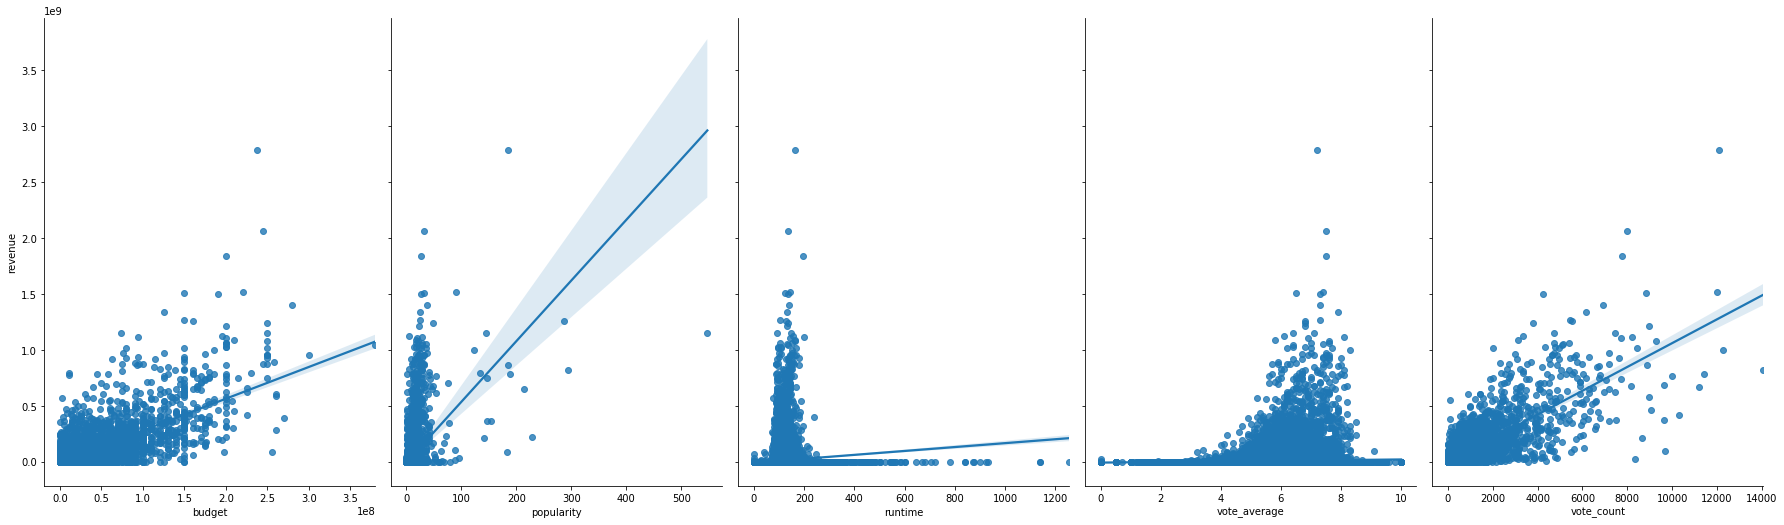

In [7]:
# filter out 0 revenue movies
import seaborn as sns
# plot relationship to revenue
sns.pairplot(df_movie, 
             x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

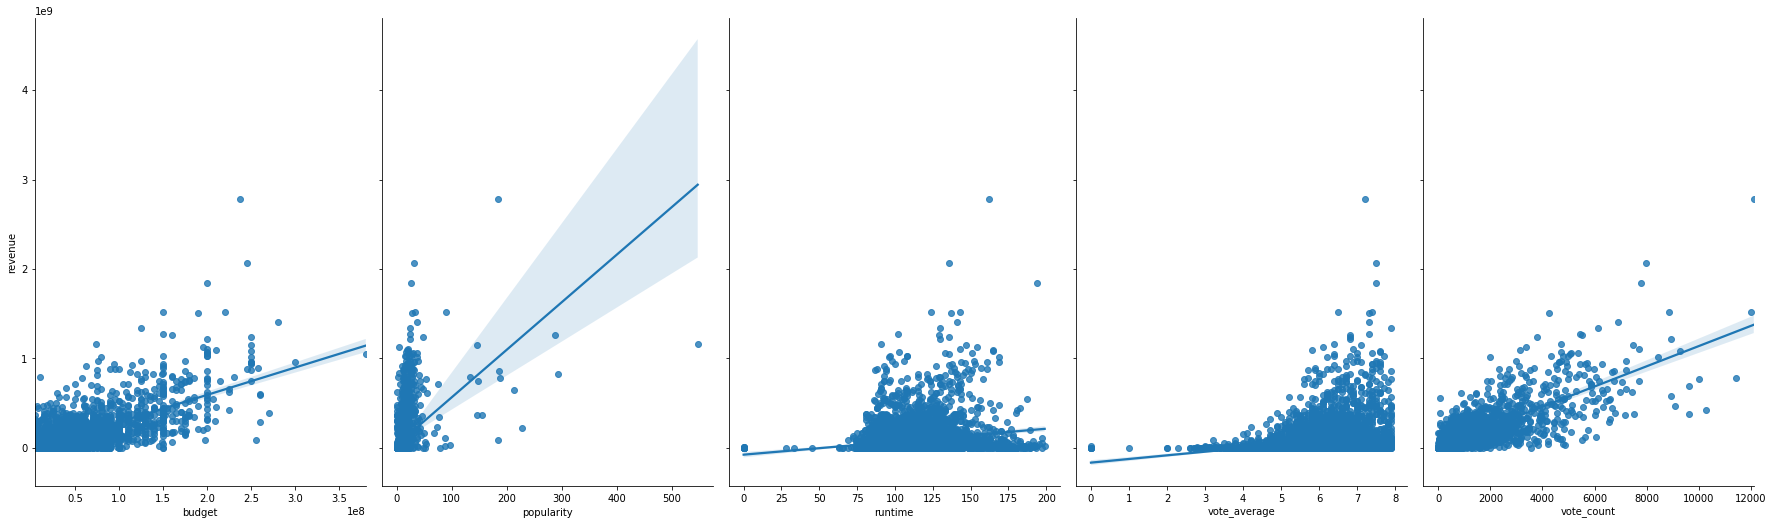

In [8]:
sns.pairplot(df_movie[np.logical_and(df_movie['vote_average'] < 8,
                                     np.logical_and(df_movie['runtime'] < 200, df_movie['budget'] > 4224578))], 
                      x_vars=x, y_vars='revenue', kind='reg', height=7, aspect=0.7)

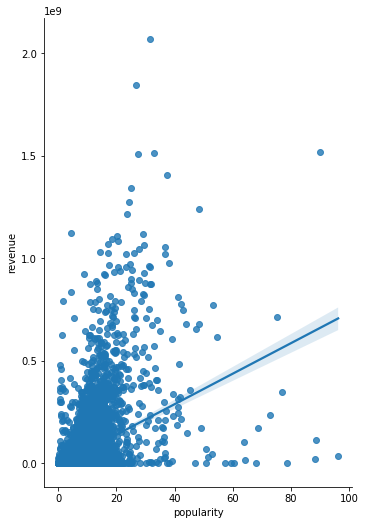

In [9]:
# popularity has extremely big r^2 value
sns.pairplot(df_movie[df_movie['popularity'] < 100], x_vars=['popularity'], y_vars='revenue', kind='reg', height=7, aspect=0.7)

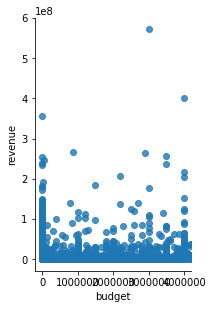

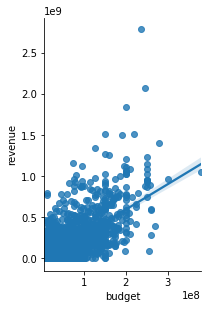

In [10]:
# too much variability in low budget films. Only going to target mainstream films for predictability.
sns.pairplot(df_movie[df_movie['budget'] <= 4224578], x_vars=['budget'], y_vars='revenue', kind='reg', height=4, aspect=0.7)
sns.pairplot(df_movie[df_movie['budget'] > 4224578], x_vars=['budget'], y_vars='revenue', kind='reg', height=4, aspect=0.7)

44864
339


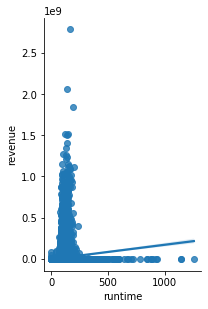

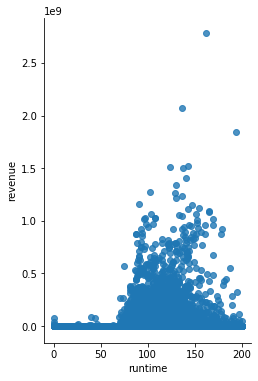

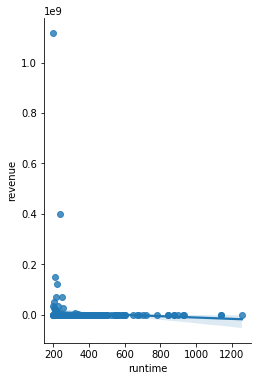

In [11]:
# too short or too long of films have really low revenue. Gaussian and therefore can't use linear regression 
# may need to cut off the films that are too long
sns.pairplot(df_movie, x_vars=['runtime'], y_vars='revenue', kind='reg', height=4, aspect=0.7)
sns.pairplot(df_movie[df_movie['runtime'] <= 200], x_vars=['runtime'], y_vars='revenue', kind='reg', height=5, aspect=0.7)
print(len(df_movie[df_movie['runtime'] <= 200]))
sns.pairplot(df_movie[df_movie['runtime'] > 200], x_vars=['runtime'], y_vars='revenue', kind='reg', height=5, aspect=0.7)
print(len(df_movie[df_movie['runtime'] > 200]))

# FEATURE EXTRACTION

In [12]:
df_movie['genres']

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [87]:
df_movie_cleaned = df_movie

movie_cols = ['id', 'title', 'revenue', 'is_collection', 'adult', 'popularity', 
              'vote_average', 'vote_count', 'runtime', 'budget', 'genres']

df_movie_cleaned = df_movie_cleaned[movie_cols]

filter_outlier = np.logical_and(df_movie_cleaned['vote_average'] < 8,
                                               np.logical_and(df_movie_cleaned['runtime'] < 200,
                                                              df_movie_cleaned['budget'] > 4224578))

df_movie_cleaned = df_movie_cleaned[filter_outlier].reset_index(drop=True)
df_movie_cleaned = df_movie_cleaned.reset_index(drop=True)

# one hot encoding on categorical features
# original language
# DROP_FIRST needed because if the first category is implied if all other cols are 0.
# df_movie_cleaned = df_movie_cleaned.join(pd.get_dummies(df_movie[['id', 'original_language']], 
#                                                         columns=['original_language'],
#                                                         prefix='lang',
#                                                         drop_first=True))
# print(pd.get_dummies(df_movie[['original_language']], 
#                                                         columns=['original_language'],
#                                                         prefix='lang',
#                                                         drop_first=True))

df_movie_cleaned['genres'] = df_movie_cleaned['genres'].apply(lambda x: x if ast.literal_eval(x) else "[{\'name\': \'unknown\'}]")
df_movie_cleaned['genres'] = df_movie_cleaned['genres'].apply(lambda x: [d['name'].replace(' ', '_').lower() \
                                                                         for d in ast.literal_eval(x) if ast.literal_eval(x)])

df_movie_cleaned = df_movie_cleaned.drop('genres', 1).join(
        pd.get_dummies(
            pd.DataFrame(df_movie_cleaned.genres.tolist()).stack()
        ).astype(int).sum(level=0)
    )

# Drop rows with any NAN

df_movie_cleaned = df_movie_cleaned.dropna()

df_movie_cleaned.astype({
    'is_collection': 'int32',
    'adult': 'int32',
    'popularity': 'float',
    'revenue': 'float',
    'vote_average': 'float',
    'vote_count': 'float',
    'runtime': 'float',
    'budget':  'int32'
})


# df_movie_cleaned = df_movie_cleaned[df_movie_cleaned['revenue'] != 0]


print('Dataset length:{}'.format(len(df_movie_cleaned)))

print(df_movie_cleaned.columns)


Dataset length:5482
Index(['id', 'title', 'revenue', 'is_collection', 'adult', 'popularity',
       'vote_average', 'vote_count', 'runtime', 'budget', 'action',
       'adventure', 'animation', 'comedy', 'crime', 'documentary', 'drama',
       'family', 'fantasy', 'foreign', 'history', 'horror', 'music', 'mystery',
       'romance', 'science_fiction', 'thriller', 'tv_movie', 'unknown', 'war',
       'western'],
      dtype='object')


# LINEAR REGRESSION MODEL

In [89]:
df_movie_cleaned = df_movie_cleaned.drop(['id', 'title'], axis=1)
x = df_movie_cleaned.iloc[:, 1:].values
y = df_movie_cleaned.iloc[:, 0].values

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

# Make Prediction
df_result = pd.DataFrame()
y_predicted = regressor.predict(x_test)
combined = np.concatenate((np.vstack((y_test)), x_test), axis=1)
df_result = pd.DataFrame(data=combined, columns=df_movie_cleaned.columns)
y_predicted = y_predicted.clip(min=0) # revenue can't be less than 0

# df_result['difference'] = np.absolute(df_result['predicted_revenue']-df_result['revenue'])/df_result['revenue']


# MODEL VALIDATION

In [97]:

import math
print('interecept: {}'.format(regressor.intercept_))
print('COEFFICIENTS')
d_coefficient = {col:regressor.coef_[i] for i,col in enumerate(df_movie_cleaned.iloc[:, 1:].columns)}
# print(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)))
l_coef = sorted(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)),
                key=lambda x: x[1], reverse=True)
# print(sorted(list(zip(df_movie_cleaned.iloc[:, 1:].columns, regressor.coef_)), key=lambda x: abs(x[1]), reverse=True))
for coef in l_coef:
    print('{}: {}'.format(coef[0], coef[1]))

interecept: -20663720.88693875
COEFFICIENTS
animation: 22424221.834080566
unknown: 17549023.34701054
documentary: 17416473.51834709
family: 15102962.107105663
adventure: 12296434.510486552
music: 11450608.974157786
foreign: 10755291.657708686
romance: 10134946.67904995
tv_movie: 8738687.310732864
comedy: 4382713.351631535
popularity: 940513.6957886469
fantasy: 581026.9959757534
runtime: 366750.99337791104
vote_count: 71186.98228611256
budget: 1.448411469323156
adult: 0.29158229538043035
mystery: -92163.65373654263
horror: -340796.028819779
vote_average: -485368.8546822923
thriller: -2060094.6331233452
drama: -3968724.6556825167
history: -5569486.314898175
war: -6188809.784045244
action: -8626446.659437763
crime: -9837085.173115302
science_fiction: -26418655.91833093
western: -28935694.6485764
is_collection: -45500437.8261615


In [91]:
# R^2 value of the model
print(regressor.score(x_test, y_test))
# calculate MAE, MSE, 
from sklearn import metrics
print(y_predicted.mean())
print(metrics.mean_absolute_error(y_test, y_predicted))
print(metrics.mean_squared_error(y_test, y_predicted))
print(np.sqrt(metrics.mean_squared_error(y_test, y_predicted)))

0.7558826029378483
83980302.36356442
40706186.70859243
5506898039998053.0
74208476.87426318


## USING OLS INSTEAD OF SCIKIT LEARN

In [93]:
from statsmodels.api import OLS
x_ols = df_movie_cleaned.iloc[:, 1:]
y_ols = df_movie_cleaned.iloc[:, 0]
ols_model = OLS(y_ols,x_ols).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                revenue   R-squared (uncentered):                   0.802
Model:                            OLS   Adj. R-squared (uncentered):              0.801
Method:                 Least Squares   F-statistic:                              819.7
Date:                Sun, 19 Apr 2020   Prob (F-statistic):                        0.00
Time:                        18:13:31   Log-Likelihood:                     -1.0761e+05
No. Observations:                5482   AIC:                                  2.153e+05
Df Residuals:                    5455   BIC:                                  2.155e+05
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
is_collection   -4.533e+07   2.91e+06    -15.598      0.000    -5.1e+07   -3.96e+07
adult               0.7597      0.050     15.113      0.000       0.661       0.858
popularity       9.704e+05   9.24e+04     10.502      0.000    7.89e+05    1.15e+06
vote_average     -2.33e+06   1.14e+06     -2.045      0.041   -4.56e+06   -9.65e+04
vote_count       7.243e+04   1405.539     51.530      0.000    6.97e+04    7.52e+04
runtime          2.802e+05   6.05e+04      4.630      0.000    1.62e+05    3.99e+05
budget              1.4965      0.040     37.158      0.000       1.418       1.575
action          -9.012e+06   2.89e+06     -3.123      0.002   -1.47e+07   -3.35e+06
adventure        5.662e+06   3.31e+06      1.709      0.088   -8.33e+05    1.22e+07
animation        1.922e+07   5.97e+06      3.218      0.001    7.51e+06    3.09e+07
comedy           2.855e+06   2.71e+06      1.053      0.293   -2.46e+06    8.17e+06
crime           -9.029e+06   3.36e+06     -2.690      0.007   -1.56e+07   -2.45e+06
documentary      1.966e+07   1.72e+07      1.142      0.254   -1.41e+07    5.34e+07
drama           -3.693e+06   2.79e+06     -1.321      0.186   -9.17e+06    1.79e+06
family           1.426e+07   4.53e+06      3.151      0.002    5.39e+06    2.31e+07
fantasy         -4.009e+06   3.94e+06     -1.017      0.309   -1.17e+07    3.72e+06
foreign          1.196e+07    1.5e+07      0.798      0.425   -1.74e+07    4.13e+07
history         -5.931e+06   5.58e+06     -1.063      0.288   -1.69e+07       5e+06
horror           -3.08e+06   4.04e+06     -0.762      0.446    -1.1e+07    4.84e+06
music            7.028e+06   6.23e+06      1.128      0.259   -5.18e+06    1.92e+07
mystery         -3.723e+06   4.35e+06     -0.856      0.392   -1.22e+07     4.8e+06
romance          1.216e+07   3.14e+06      3.868      0.000       6e+06    1.83e+07
science_fiction -2.718e+07   3.67e+06     -7.414      0.000   -3.44e+07      -2e+07
thriller        -2.002e+06   2.93e+06     -0.683      0.495   -7.75e+06    3.75e+06
tv_movie         1.069e+07   2.12e+07      0.505      0.614   -3.08e+07    5.22e+07
unknown          1.504e+07    3.1e+07      0.485      0.627   -4.57e+07    7.58e+07
war             -5.685e+06   6.06e+06     -0.939      0.348   -1.76e+07    6.19e+06
western           -2.7e+07   8.89e+06     -3.039      0.002   -4.44e+07   -9.58e+06
==============================================================================
Omnibus:                     4114.800   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           326257.889
Skew:                           2.937   Prob(JB):                         0.00
Kurtosis:                      40.334   Cond. No.               

/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


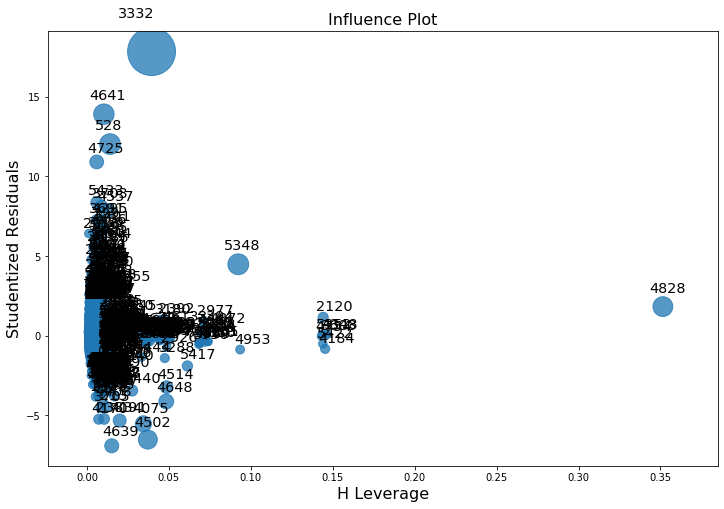

In [96]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(ols_model, ax=ax, criterion="cooks")

In [213]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder# instantiate OneHotEncoder
df_movie['original_language']
ohe = OneHotEncoder().fit(df_movie['original_language']) 
# categorical_features = boolean mask for categorical columns
# sparse = False output an array not sparse matrix

ValueError: Expected 2D array, got 1D array instead:
array=['en' 'en' 'en' ... 'en' 'en' 'en'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [14]:
import re

df_credit
import ast
keywords = ast.literal_eval(df_keywords.iloc[0]['keywords'])
keywords
# re.split("},", df_credit.iloc[0]['cast'].strip(']['))
# df_credit.iloc[0]['cast'].strip('][')
# pd.to_numeric(df_movie['popularity'])
# df_movie.iloc[35587]

[{'id': 931, 'name': 'jealousy'},
 {'id': 4290, 'name': 'toy'},
 {'id': 5202, 'name': 'boy'},
 {'id': 6054, 'name': 'friendship'},
 {'id': 9713, 'name': 'friends'},
 {'id': 9823, 'name': 'rivalry'},
 {'id': 165503, 'name': 'boy next door'},
 {'id': 170722, 'name': 'new toy'},
 {'id': 187065, 'name': 'toy comes to life'}]

In [2]:
df_credit = pd.read_csv('credits.csv')
pd.get_dummies(
        pd.DataFrame(df_credit.cast_list.tolist()).stack()
    ).astype(int).sum(level=0)

NameError: name 'pd' is not defined

In [58]:
df_credit = df_credit.reset_index(drop=True)
df_movie_cleaned = df_movie_cleaned.reset_index(drop=True)
print(df_credit.id.dtype, df_movie_cleaned.id.dtype)

object object


In [71]:
df_movie_cleaned.join(df_credit, how='left')


,id,title,revenue,is_collection,adult,popularity,vote_average,vote_count,runtime,budget,...,mystery,romance,science_fiction,thriller,tv_movie,unknown,war,western,cast,crew
0,862,Toy Story,373554033.0,0,0,21.946943,7.7,5415.0,81.0,30000000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
1,8844,Jumanji,262797249.0,1,0,17.015539,6.9,2413.0,104.0,65000000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,31357,Waiting to Exhale,81452156.0,1,0,3.859495,6.1,34.0,127.0,16000000.0,...,0,1,0,0,0,0,0,0,"[{'cast_id': 3, 'character': 'Taisto Olavi Kas...","[{'credit_id': '52fe420dc3a36847f800001f', 'de..."
3,949,Heat,187436818.0,1,0,17.924927,7.7,1886.0,170.0,60000000.0,...,0,0,0,1,0,0,0,0,"[{'cast_id': 5, 'character': 'Nikander', 'cred...","[{'credit_id': '52fe420dc3a36847f8000077', 'de..."
4,11860,Sabrina,0.0,1,0,6.677277,6.2,141.0,127.0,58000000.0,...,0,1,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5477,24049,Sivaji: The Boss,19000000.0,1,0,1.323587,6.9,25.0,185.0,12000000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
5478,277839,"Good Guys Go to Heaven, Bad Guys Go to Pattaya",0.0,1,0,5.613875,5.3,153.0,100.0,5402000.0,...,0,0,0,0,0,0,0,0,NaN,NaN
5479,248705,The Visitors: Bastille Day,0.0,0,0,7.294920,4.0,167.0,110.0,25868826.0,...,0,0,0,0,0,0,0,0,NaN,NaN
5480,39164,House of the Long Shadows,0.0,1,0,1.185515,6.1,18.0,100.0,7500000.0,...,1,0,0,0,0,0,0,0,NaN,NaN


In [3]:
# categorical_feature_mask = df_movie.dtypes==object
# categorical_feature_mask
import ast
df_credit['cast_list'] = df_credit['cast'].apply(lambda x: [cast['name'] for cast in ast.literal_eval(x)])

In [ ]:
df_credit.drop('cast_list', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_credit.cast_list.tolist()).stack()
    ).astype(int).sum(level=0)
)

In [1]:
df_credit['cast_list']

NameError: name 'df_credit' is not defined

In [105]:

df_movie['genres_list'] = df_movie['genres'].apply(lambda x: [d['name'].replace(' ', '_').lower() for d in ast.literal_eval(x)])
df_movie.drop('genres_list', 1).join(
    pd.get_dummies(
        pd.DataFrame(df_movie.genres_list.tolist()).stack()
    ).astype(int).sum(level=0)
)

,original_title,id,title,adult,belongs_to_collection,budget,genres,original_language,popularity,production_companies,...,romance,science_fiction,sentai_filmworks,telescene_film_group_productions,the_cartel,thriller,tv_movie,vision_view_entertainment,war,western
0,Toy Story,862,Toy Story,0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Jumanji,8844,Jumanji,0,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Grumpier Old Men,15602,Grumpier Old Men,0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Waiting to Exhale,31357,Waiting to Exhale,0,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Father of the Bride Part II,11862,Father of the Bride Part II,0,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,رگ خواب,439050,Subdue,0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",fa,0.072051,[],...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45462,Siglo ng Pagluluwal,111109,Century of Birthing,0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",tl,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45463,Betrayal,67758,Betrayal,0,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",en,0.903007,"[{'name': 'American World Pictures', 'id': 6165}]",...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45464,Satana likuyushchiy,227506,Satan Triumphant,0,NaN,0.0,[],en,0.003503,"[{'name': 'Yermoliev', 'id': 88753}]",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder# instantiate OneHotEncoder
df_movie['genre_cleaned'] = df_movie['genres'].apply(lambda x: [d['name'] for d in ast.literal_eval(x)])

df_movie['is_collection'] = df_movie['belongs_to_collection'].isnull()
df_movie['is_collection'] = df_movie['is_collection'].apply(lambda x: 1 if x==True else 0)
df_movie['is_collection']

df_movie['adult'] = df_movie['adult'].apply(lambda x: 1 if x==True else 0)

df_movie['popularity'] = 
df_movie.astype({
    'is_collection': 'int32',
    'adult': 'int32',
    'popularity': 'float'
})

# df_movie['is_collection']
# df_movie['genre_cleaned'] 
# ohe = OneHotEncoder().fit(df_movie['genre_cleaned']) 
# categorical_features = boolean mask for categorical columns
# sparse = False output an array not sparse matrix

In [ ]:
df_movie['budget'].mean()

In [ ]:
df_result

In [172]:
df_movie

,original_title,id,title,adult,belongs_to_collection,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,spoken_languages,status,vote_average,vote_count,genres_parsed,is_collection,genre_cleaned
0,Toy Story,862,Toy Story,0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",en,21.946943,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,7.7,5415.0,"[Animation, Comedy, Family]",0,"[animation, comedy, family]"
1,Jumanji,8844,Jumanji,0,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",en,17.015539,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,6.9,2413.0,"[Adventure, Fantasy, Family]",1,"[adventure, fantasy, family]"
2,Grumpier Old Men,15602,Grumpier Old Men,0,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",en,11.712900,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.5,92.0,"[Romance, Comedy]",0,"[romance, comedy]"
3,Waiting to Exhale,31357,Waiting to Exhale,0,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",en,3.859495,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,6.1,34.0,"[Comedy, Drama, Romance]",1,"[comedy, drama, romance]"
4,Father of the Bride Part II,11862,Father of the Bride Part II,0,"{'id': 96871, 'name': 'Father of the Bride Col...",0.0,"[{'id': 35, 'name': 'Comedy'}]",en,8.387519,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,5.7,173.0,[Comedy],0,[comedy]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,رگ خواب,439050,Subdue,0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",fa,0.072051,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,4.0,1.0,"[Drama, Family]",1,"[drama, family]"
45462,Siglo ng Pagluluwal,111109,Century of Birthing,0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",tl,0.178241,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,9.0,3.0,[Drama],1,[drama]
45463,Betrayal,67758,Betrayal,0,NaN,0.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",en,0.903007,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,3.8,6.0,"[Action, Drama, Thriller]",1,"[action, drama, thriller]"
45464,Satana likuyushchiy,227506,Satan Triumphant,0,NaN,0.0,[],en,0.003503,"[{'name': 'Yermoliev', 'id': 88753}]","[{'iso_3166_1': 'RU', 'name': 'Russia'}]",0.0,87.0,[],Released,0.0,0.0,[],1,[]


In [173]:
df_result

,index,revenue,is_collection,adult,popularity,vote_average,vote_count,runtime,budget
0,4924.0,10219460.0,1.0,0.0,9.974312,6.3,65.0,106.0,15000000.0
1,15670.0,7022728.0,1.0,0.0,6.632194,6.1,212.0,96.0,10000000.0
2,1096.0,0.0,0.0,0.0,4.883274,7.6,113.0,120.0,4940939.0
3,21815.0,15008161.0,0.0,0.0,9.251084,5.3,642.0,107.0,12000000.0
4,22.0,30303072.0,1.0,0.0,11.065939,6.0,394.0,132.0,50000000.0
...,...,...,...,...,...,...,...,...,...
1092,14489.0,0.0,1.0,0.0,10.952545,7.3,475.0,101.0,7000000.0
1093,7375.0,51718367.0,1.0,0.0,4.621214,7.0,99.0,122.0,5900000.0
1094,40721.0,0.0,1.0,0.0,9.809168,6.3,436.0,139.0,45000000.0
1095,1517.0,44862187.0,1.0,0.0,9.159310,6.6,384.0,104.0,15000000.0


In [70]:
df_credit

,cast,crew
id,,
862,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
8844,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
15602,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
31357,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
11862,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."
...,...,...
439050,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '5894a97d925141426c00818c', 'de..."
111109,"[{'cast_id': 1002, 'character': 'Sister Angela...","[{'credit_id': '52fe4af1c3a36847f81e9b15', 'de..."
67758,"[{'cast_id': 6, 'character': 'Emily Shaw', 'cr...","[{'credit_id': '52fe4776c3a368484e0c8387', 'de..."
